## <p style = "text-align: center; font-weight: bold;">Analyzing Leading Causes of Death in Canada</p>

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Importing Data</p>
-----------------------------------------------------------------------------------------

#### HDFS

In [1]:
!start-all.sh
!hdfs dfsadmin -safemode leave

Starting namenodes on [0.0.0.0]
Starting datanodes
Starting secondary namenodes [Bikins-MacBook-Pro.local]
2024-04-13 11:07:26,645 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting resourcemanager
Starting nodemanagers
2024-04-13 11:07:34,759 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Safe mode is OFF


In [2]:
# Connect to the Hadoop cluster
from hdfs import InsecureClient

# Connect to HDFS
client_hdfs = InsecureClient('http://localhost:9870', user='bikinghimire')

In [3]:
# Create the project directory
client_hdfs.makedirs('/DTSPROJECT')

# Upload the dataset
client_hdfs.upload('/DTSPROJECT', 'Datasets/OriginalData.csv')

In [6]:
# Removing the header from the dataser
!hdfs dfs -cat hdfs://localhost:19000/DTSPROJECT/OriginalData.csv | tail -n +2 | hdfs dfs -put - hdfs://localhost:19000/DTSPROJECT/OriginalData_noheader.csv

2024-04-13 11:08:12,776 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-04-13 11:08:12,792 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
# List files in the project directory
client_hdfs.list('/DTSPROJECT')

['OriginalData.csv', 'OriginalData_MetaData.csv', 'OriginalData_noheader.csv']

#### Spark and Loading Data to Hive Table

In [8]:
# Establish a connection to Hive
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("HiveAnalysis").enableHiveSupport().getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/13 11:08:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# Create a Hive database
spark.sql("CREATE DATABASE IF NOT EXISTS db_DTS")

# Use the Hive database
spark.sql("USE db_DTS")

24/04/13 11:08:46 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/13 11:08:46 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/13 11:08:50 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/13 11:08:50 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore bikinghimire@10.0.0.53
24/04/13 11:08:50 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


DataFrame[]

In [10]:
# Creating the HIVE table to store data

spark.sql("DROP TABLE IF EXISTS original_data")

q_create_tbl = """
CREATE TABLE IF NOT EXISTS original_data (
    REF_DATE INT,
    GEO STRING,
    DGUID STRING,
    Age_at_the_time_of_death STRING,
    Sex STRING,
    Leading_cause_of_death STRING,
    Characteristics STRING,
    UOM STRING,
    UOM_ID INT,
    SCALAR_FACTOR STRING,
    SCALAR_ID STRING,
    VECTOR STRING,
    COORDINATE STRING,
    VALUE STRING,
    STATUS STRING,
    SYMBOL STRING,
    TERMINATED STRING,
    DECIMALS STRING
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar' = '\"',
    'escapeChar' = '\\\\'
)
STORED AS TEXTFILE;
"""

# Run the query to create the table
spark.sql(q_create_tbl)

# Load the data into the table from HDFS and skip the first row of data
spark.sql("LOAD DATA INPATH 'hdfs://localhost:19000/DTSPROJECT/OriginalData_noheader.csv' INTO TABLE original_data;")

24/04/13 11:09:02 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:string,age_at_the_time_of_death:string,sex:string,leading_cause_of_death:string,characteristics:string,uom:string,uom_id:string,scalar_factor:string,scalar_id:string,vector:string,coordinate:string,value:string,status:string,symbol:string,terminated:string,decimals:string>) is different from the schema when this table was created by Spark SQL(struct<REF_DATE:int,GEO:string,DGUID:string,Age_at_the_time_of_death:string,Sex:string,Leading_cause_of_death:string,Characteristics:string,UOM:string,UOM_ID:int,SCALAR_FACTOR:string,SCALAR_ID:string,VECTOR:string,COORDINATE:string,VALUE:string,STATUS:string,SYMBOL:string,TERMINATED:string,DECIMALS:string>). We have to fall back to the table schema from Hive metastore which is not case preserving.
24/04/13 11:09:02 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:stri

DataFrame[]

In [11]:
# Displaying the structure of the table
print("Table structure")
spark.sql("DESCRIBE original_data").show()
print("\n")

# Displaying the count of rows in the table
print("Number of rows")
spark.sql("SELECT COUNT(*) FROM original_data").show()
print("\n")

# Displaying the top 10 rows of the table
print("Top 10 rows")
spark.sql("SELECT * FROM original_data").show()
print("\n")

Table structure


24/04/13 11:09:48 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:string,age_at_the_time_of_death:string,sex:string,leading_cause_of_death:string,characteristics:string,uom:string,uom_id:string,scalar_factor:string,scalar_id:string,vector:string,coordinate:string,value:string,status:string,symbol:string,terminated:string,decimals:string>) is different from the schema when this table was created by Spark SQL(struct<REF_DATE:int,GEO:string,DGUID:string,Age_at_the_time_of_death:string,Sex:string,Leading_cause_of_death:string,Characteristics:string,UOM:string,UOM_ID:int,SCALAR_FACTOR:string,SCALAR_ID:string,VECTOR:string,COORDINATE:string,VALUE:string,STATUS:string,SYMBOL:string,TERMINATED:string,DECIMALS:string>). We have to fall back to the table schema from Hive metastore which is not case preserving.
24/04/13 11:09:48 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:stri

+--------------------+---------+-----------------+
|            col_name|data_type|          comment|
+--------------------+---------+-----------------+
|            ref_date|   string|from deserializer|
|                 geo|   string|from deserializer|
|               dguid|   string|from deserializer|
|age_at_the_time_o...|   string|from deserializer|
|                 sex|   string|from deserializer|
|leading_cause_of_...|   string|from deserializer|
|     characteristics|   string|from deserializer|
|                 uom|   string|from deserializer|
|              uom_id|   string|from deserializer|
|       scalar_factor|   string|from deserializer|
|           scalar_id|   string|from deserializer|
|              vector|   string|from deserializer|
|          coordinate|   string|from deserializer|
|               value|   string|from deserializer|
|              status|   string|from deserializer|
|              symbol|   string|from deserializer|
|          terminated|   string

24/04/13 11:09:50 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:string,age_at_the_time_of_death:string,sex:string,leading_cause_of_death:string,characteristics:string,uom:string,uom_id:string,scalar_factor:string,scalar_id:string,vector:string,coordinate:string,value:string,status:string,symbol:string,terminated:string,decimals:string>) is different from the schema when this table was created by Spark SQL(struct<REF_DATE:int,GEO:string,DGUID:string,Age_at_the_time_of_death:string,Sex:string,Leading_cause_of_death:string,Characteristics:string,UOM:string,UOM_ID:int,SCALAR_FACTOR:string,SCALAR_ID:string,VECTOR:string,COORDINATE:string,VALUE:string,STATUS:string,SYMBOL:string,TERMINATED:string,DECIMALS:string>). We have to fall back to the table schema from Hive metastore which is not case preserving.


+--------+
|count(1)|
+--------+
|  407334|
+--------+



Top 10 rows


24/04/13 11:09:55 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:string,age_at_the_time_of_death:string,sex:string,leading_cause_of_death:string,characteristics:string,uom:string,uom_id:string,scalar_factor:string,scalar_id:string,vector:string,coordinate:string,value:string,status:string,symbol:string,terminated:string,decimals:string>) is different from the schema when this table was created by Spark SQL(struct<REF_DATE:int,GEO:string,DGUID:string,Age_at_the_time_of_death:string,Sex:string,Leading_cause_of_death:string,Characteristics:string,UOM:string,UOM_ID:int,SCALAR_FACTOR:string,SCALAR_ID:string,VECTOR:string,COORDINATE:string,VALUE:string,STATUS:string,SYMBOL:string,TERMINATED:string,DECIMALS:string>). We have to fall back to the table schema from Hive metastore which is not case preserving.


+--------+--------------------+--------------+------------------------+----------+----------------------+--------------------+----------+------+-------------+---------+---------+-----------+------+------+------+----------+--------+
|ref_date|                 geo|         dguid|age_at_the_time_of_death|       sex|leading_cause_of_death|     characteristics|       uom|uom_id|scalar_factor|scalar_id|   vector| coordinate| value|status|symbol|terminated|decimals|
+--------+--------------------+--------------+------------------------+----------+----------------------+--------------------+----------+------+-------------+---------+---------+-----------+------+------+------+----------+--------+
|    2000|Canada, place of ...|2016A000011124|    Age at time of de...|Both sexes|  Total, all causes...|    Number of deaths|    Number|   223|        units|        0|v41618016|1.1.1.100.2|218062|      |      |          |       0|
|    2000|Canada, place of ...|2016A000011124|    Age at time of de...|B

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Cleaning</p>
-----------------------------------------------------------------------------------------

In [12]:
# Selecting only required columns and creating a new table
spark.sql("DROP TABLE IF EXISTS selected_columns")
spark.sql("CREATE TABLE IF NOT EXISTS selected_columns AS SELECT REF_DATE, Age_at_the_time_of_death AS Age_Range, Sex, Leading_cause_of_death, Characteristics, Value FROM original_data")

24/04/13 11:10:23 WARN HiveExternalCatalog: The table schema given by Hive metastore(struct<ref_date:string,geo:string,dguid:string,age_at_the_time_of_death:string,sex:string,leading_cause_of_death:string,characteristics:string,uom:string,uom_id:string,scalar_factor:string,scalar_id:string,vector:string,coordinate:string,value:string,status:string,symbol:string,terminated:string,decimals:string>) is different from the schema when this table was created by Spark SQL(struct<REF_DATE:int,GEO:string,DGUID:string,Age_at_the_time_of_death:string,Sex:string,Leading_cause_of_death:string,Characteristics:string,UOM:string,UOM_ID:int,SCALAR_FACTOR:string,SCALAR_ID:string,VECTOR:string,COORDINATE:string,VALUE:string,STATUS:string,SYMBOL:string,TERMINATED:string,DECIMALS:string>). We have to fall back to the table schema from Hive metastore which is not case preserving.
24/04/13 11:10:23 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can

DataFrame[]

In [13]:
spark.sql("SELECT * FROM selected_columns").show()

# Count number of rows
spark.sql("SELECT COUNT(*) FROM selected_columns").show()

+--------+--------------------+----------+----------------------+--------------------+------+
|REF_DATE|           Age_Range|       Sex|Leading_cause_of_death|     Characteristics| Value|
+--------+--------------------+----------+----------------------+--------------------+------+
|    2000|Age at time of de...|Both sexes|  Total, all causes...|    Number of deaths|218062|
|    2000|Age at time of de...|Both sexes|  Total, all causes...|Percentage of deaths| 100.0|
|    2000|Age at time of de...|Both sexes|  Total, all causes...|Age-specific mort...| 708.7|
|    2000|Age at time of de...|Both sexes|  Salmonella infect...|Rank of leading c...|    41|
|    2000|Age at time of de...|Both sexes|  Salmonella infect...|    Number of deaths|     3|
|    2000|Age at time of de...|Both sexes|  Salmonella infect...|Percentage of deaths|   0.0|
|    2000|Age at time of de...|Both sexes|  Salmonella infect...|Age-specific mort...|   0.0|
|    2000|Age at time of de...|Both sexes|  Shigellosis and 

In [14]:
# Checking if REF_DATE requires cleaning
spark.sql("SELECT DISTINCT REF_DATE FROM selected_columns ORDER BY REF_DATE").show(50)

+--------+
|REF_DATE|
+--------+
|    2000|
|    2001|
|    2002|
|    2003|
|    2004|
|    2005|
|    2006|
|    2007|
|    2008|
|    2009|
|    2010|
|    2011|
|    2012|
|    2013|
|    2014|
|    2015|
|    2016|
|    2017|
|    2018|
|    2019|
|    2020|
|    2021|
|    2022|
+--------+



In [15]:
# Checking if Age_Range requires cleaning
spark.sql("SELECT DISTINCT Age_Range FROM selected_columns ORDER BY Age_Range").show(50, truncate=False)

+---------------------------------------+
|Age_Range                              |
+---------------------------------------+
|Age at time of death, 1 to 14 years    |
|Age at time of death, 1 to 4 years     |
|Age at time of death, 10 to 14 years   |
|Age at time of death, 15 to 19 years   |
|Age at time of death, 15 to 24         |
|Age at time of death, 20 to 24 years   |
|Age at time of death, 25 to 29 years   |
|Age at time of death, 25 to 34 years   |
|Age at time of death, 30 to 34 years   |
|Age at time of death, 35 to 39 years   |
|Age at time of death, 35 to 44 years   |
|Age at time of death, 40 to 44 years   |
|Age at time of death, 45 to 49 years   |
|Age at time of death, 45 to 54 years   |
|Age at time of death, 5 to 9 years     |
|Age at time of death, 50 to 54 years   |
|Age at time of death, 55 to 59 years   |
|Age at time of death, 55 to 64 years   |
|Age at time of death, 60 to 64 years   |
|Age at time of death, 65 to 69 years   |
|Age at time of death, 65 to 74 ye

In [16]:
# Select all rows from selected_columns where age_range is not in the specified ranges
age_clear_query = ("""
CREATE TABLE IF NOT EXISTS age_clean AS
  SELECT *
  FROM selected_columns
  WHERE Age_Range NOT IN (
    'Age at time of death, 1 to 14 years',
    'Age at time of death, 15 to 24',
    'Age at time of death, 25 to 34 years',
    'Age at time of death, 35 to 44 years',
    'Age at time of death, 45 to 54 years',
    'Age at time of death, 55 to 64 years',
    'Age at time of death, 65 to 74 years',
    'Age at time of death, 75 to 84 years',
    'Age at time of death, 85 to 89 years',
    'Age at time of death, 90 years and over',
    'Age at time of death, all ages'
  )
""")
spark.sql("DROP TABLE IF EXISTS age_clean")
spark.sql(age_clear_query)

spark.sql("SELECT DISTINCT(Age_Range) FROM age_clean").show()


24/04/13 11:10:42 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/13 11:10:42 WARN HiveMetaStore: Location: file:/Users/bikinghimire/Projects/LeadingCausesOfDeath/spark-warehouse/db_dts.db/age_clean specified for non-external table:age_clean


+--------------------+
|           Age_Range|
+--------------------+
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
|Age at time of de...|
+--------------------+



In [17]:
# Applying regex to remove "Age at the time of death, " and " years" from the Age_Range column
spark.sql("DROP TABLE IF EXISTS age_clean_data")
age_data_query = """
CREATE TABLE IF NOT EXISTS age_clean_data AS
SELECT REF_DATE, 
       regexp_replace(regexp_replace(Age_Range, 'Age at time of death, ', ''), ' years', '') AS
         Age_Range,
         Sex, Leading_cause_of_death, Characteristics, Value
FROM age_clean;
"""
spark.sql(age_data_query)

#View the cleaned age data
spark.sql("SELECT DISTINCT(Age_Range) FROM age_clean_data").show()

24/04/13 11:10:54 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/13 11:10:54 WARN HiveMetaStore: Location: file:/Users/bikinghimire/Projects/LeadingCausesOfDeath/spark-warehouse/db_dts.db/age_clean_data specified for non-external table:age_clean_data


+-----------+
|  Age_Range|
+-----------+
|   35 to 39|
|   80 to 84|
|   30 to 34|
|   60 to 64|
|   45 to 49|
|   25 to 29|
|   15 to 19|
|   10 to 14|
|   40 to 44|
|   70 to 74|
|   55 to 59|
|   75 to 79|
|85 and over|
|   20 to 24|
|   50 to 54|
|   65 to 69|
|     5 to 9|
|     1 to 4|
+-----------+



In [18]:
# Checking if Sex requires cleaning
spark.sql("SELECT DISTINCT Sex FROM age_clean_data ORDER BY Sex").show()

# Select only the required Sex and store it in a new table
spark.sql("DROP TABLE IF EXISTS sex_clean_data")
spark.sql("CREATE TABLE IF NOT EXISTS sex_clean_data AS SELECT * FROM age_clean_data WHERE Sex != 'Both sexes'")
spark.sql("SELECT * FROM sex_clean_data").show()

+----------+
|       Sex|
+----------+
|Both sexes|
|   Females|
|     Males|
+----------+



24/04/13 11:11:00 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/13 11:11:00 WARN HiveMetaStore: Location: file:/Users/bikinghimire/Projects/LeadingCausesOfDeath/spark-warehouse/db_dts.db/sex_clean_data specified for non-external table:sex_clean_data


+--------+---------+-----+----------------------+--------------------+-----+
|REF_DATE|Age_Range|  Sex|Leading_cause_of_death|     Characteristics|Value|
+--------+---------+-----+----------------------+--------------------+-----+
|    2000|   1 to 4|Males|  Total, all causes...|    Number of deaths|  170|
|    2000|   1 to 4|Males|  Total, all causes...|Percentage of deaths|100.0|
|    2000|   1 to 4|Males|  Total, all causes...|Age-specific mort...| 22.9|
|    2000|   1 to 4|Males|  Salmonella infect...|Rank of leading c...|   18|
|    2000|   1 to 4|Males|  Salmonella infect...|    Number of deaths|    0|
|    2000|   1 to 4|Males|  Salmonella infect...|Percentage of deaths|  0.0|
|    2000|   1 to 4|Males|  Salmonella infect...|Age-specific mort...|  0.0|
|    2000|   1 to 4|Males|  Shigellosis and a...|Rank of leading c...|   18|
|    2000|   1 to 4|Males|  Shigellosis and a...|    Number of deaths|    0|
|    2000|   1 to 4|Males|  Shigellosis and a...|Percentage of deaths|  0.0|

In [19]:
# Checking if Characteristics requires cleaning
spark.sql("SELECT DISTINCT Characteristics FROM sex_clean_data").show()

# Select only the required characteristic and store it in a new table
spark.sql("DROP TABLE IF EXISTS death_clean_data")
spark.sql("CREATE TABLE IF NOT EXISTS death_clean_data AS SELECT * FROM sex_clean_data WHERE Characteristics = 'Number of deaths'")
spark.sql("SELECT * FROM death_clean_data").show()

+--------------------+
|     Characteristics|
+--------------------+
|Rank of leading c...|
|Percentage of deaths|
|    Number of deaths|
|Age-specific mort...|
+--------------------+



24/04/13 11:11:08 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/13 11:11:08 WARN HiveMetaStore: Location: file:/Users/bikinghimire/Projects/LeadingCausesOfDeath/spark-warehouse/db_dts.db/death_clean_data specified for non-external table:death_clean_data


+--------+---------+-----+----------------------+----------------+-----+
|REF_DATE|Age_Range|  Sex|Leading_cause_of_death| Characteristics|Value|
+--------+---------+-----+----------------------+----------------+-----+
|    2000|   1 to 4|Males|  Total, all causes...|Number of deaths|  170|
|    2000|   1 to 4|Males|  Salmonella infect...|Number of deaths|    0|
|    2000|   1 to 4|Males|  Shigellosis and a...|Number of deaths|    0|
|    2000|   1 to 4|Males|  Tuberculosis [A16...|Number of deaths|    0|
|    2000|   1 to 4|Males|  Whooping cough [A37]|Number of deaths|    0|
|    2000|   1 to 4|Males|  Scarlet fever and...|Number of deaths|    0|
|    2000|   1 to 4|Males|  Meningococcal inf...|Number of deaths|    1|
|    2000|   1 to 4|Males|      Sepsis [A40-A41]|Number of deaths|    3|
|    2000|   1 to 4|Males|    Syphilis [A50-A53]|Number of deaths|    0|
|    2000|   1 to 4|Males|  Acute poliomyelit...|Number of deaths|    0|
|    2000|   1 to 4|Males|  Arthropod-borne v...|Nu

In [20]:
# Remove total causes of death from the data
spark.sql("DROP TABLE IF EXISTS final_clean_data")
spark.sql("CREATE TABLE IF NOT EXISTS final_clean_data AS SELECT REF_DATE AS Year, Age_Range, Sex, Leading_cause_of_death AS Leading_Cause_Of_Death, Value AS Death_Count FROM death_clean_data WHERE Leading_cause_of_death != 'Total, all causes of death [A00-Y89]'")
spark.sql("SELECT * FROM final_clean_data").show()

24/04/13 11:11:11 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/13 11:11:12 WARN HiveMetaStore: Location: file:/Users/bikinghimire/Projects/LeadingCausesOfDeath/spark-warehouse/db_dts.db/final_clean_data specified for non-external table:final_clean_data


+----+---------+-------+----------------------+-----------+
|Year|Age_Range|    Sex|Leading_Cause_Of_Death|Death_Count|
+----+---------+-------+----------------------+-----------+
|2015| 35 to 39|Females|  Operations of war...|          0|
|2015| 35 to 39|Females|  Complications of ...|          1|
|2015| 35 to 39|Females|  Other causes of d...|        130|
|2015| 40 to 44|  Males|  Salmonella infect...|          0|
|2015| 40 to 44|  Males|  Shigellosis and a...|          0|
|2015| 40 to 44|  Males|  Tuberculosis [A16...|          1|
|2015| 40 to 44|  Males|  Whooping cough [A37]|          0|
|2015| 40 to 44|  Males|  Scarlet fever and...|          0|
|2015| 40 to 44|  Males|  Meningococcal inf...|          0|
|2015| 40 to 44|  Males|      Sepsis [A40-A41]|          7|
|2015| 40 to 44|  Males|    Syphilis [A50-A53]|          0|
|2015| 40 to 44|  Males|  Acute poliomyelit...|          0|
|2015| 40 to 44|  Males|  Arthropod-borne v...|          0|
|2015| 40 to 44|  Males|         Measles

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Analysis</p>
-----------------------------------------------------------------------------------------

In [30]:
# Import the required libraries
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, desc, mean, max, min, sum, count, split, rank, lag, struct

In [22]:
# Load the final_clean_data table from Hive into a Spark DataFrame
df = spark.sql("SELECT * FROM final_clean_data")

# Display the schema of the DataFrame
df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Age_Range: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Leading_Cause_Of_Death: string (nullable = true)
 |-- Death_Count: string (nullable = true)



In [23]:
# Change the data types of the columns
df = df.withColumn("Year", df["Year"].cast(IntegerType()))
df = df.withColumn("Death_Count", df["Death_Count"].cast(IntegerType()))

# Display the schema of the DataFrame
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Age_Range: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Leading_Cause_Of_Death: string (nullable = true)
 |-- Death_Count: integer (nullable = true)



In [24]:
# Properly sorting the data
df = df.orderBy('Year', 'Age_Range', 'Sex', 'Leading_Cause_Of_Death', 'Death_Count')

In [25]:
# Aggregations
# Total count of deaths
total_deaths = df.select(sum('Death_Count').alias('Total Deaths')).collect()[0]['Total Deaths']

# Total deaths by year
deaths_by_year = df.groupBy('Year').agg(sum('Death_Count').alias('Total Deaths')).orderBy('Year')

# Total deaths by cause of death
deaths_by_cause = df.groupBy('Leading_Cause_Of_Death').agg(sum('Death_Count').alias('Total Deaths')).orderBy(desc('Total Deaths'))

# Total deaths by age range
deaths_by_age = df.groupBy('Age_range').agg(sum('Death_Count').alias('Total Deaths')).orderBy('Age_Range').sort('Total Deaths', ascending=False)

# Total deaths by sex
deaths_by_sex = df.groupBy('Sex').agg(sum('Death_Count').alias('Total Deaths'))

In [26]:
# Insights

# Most common cause of death
most_common_cause = deaths_by_cause.first()

# Age range with highest number of deaths
age_max_deaths = deaths_by_age.first()

# Year with highest number of deaths
year_max_deaths = deaths_by_year.sort('Total Deaths', ascending=False).first()

In [27]:
# Print the results
print("Total deaths:", total_deaths)
print("Total deaths by year:")
deaths_by_year.show()
print("Total deaths by cause of death:")
deaths_by_cause.show(truncate=False)
print("Total deaths by age range:")
deaths_by_age.show()
print("Total deaths by sex:")
deaths_by_sex.show()
print("Most common cause of death:", most_common_cause)
print("Age range with highest number of deaths:", age_max_deaths)
print("Year with the highest number of deaths:", year_max_deaths)

Total deaths: 5819828
Total deaths by year:
+----+------------+
|Year|Total Deaths|
+----+------------+
|2000|      216318|
|2001|      217796|
|2002|      221838|
|2003|      224400|
|2004|      224805|
|2005|      228266|
|2006|      226295|
|2007|      233331|
|2008|      236701|
|2009|      236544|
|2010|      238173|
|2011|      241662|
|2012|      244778|
|2013|      250454|
|2014|      257027|
|2015|      262596|
|2016|      265472|
|2017|      276573|
|2018|      283912|
|2019|      283644|
+----+------------+
only showing top 20 rows

Total deaths by cause of death:
+---------------------------------------------------------------------------------------------+------------+
|Leading_Cause_Of_Death                                                                       |Total Deaths|
+---------------------------------------------------------------------------------------------+------------+
|Malignant neoplasms [C00-C97]                                                             

In [33]:
# Group the data by Age_Range and Leading_Cause_Of_Death, and calculate the max Death_Count for each group
max_cause_by_age = df.groupBy('Age_Range', 'Leading_Cause_Of_Death').agg(max('Death_Count').alias('Max_Death_Count'))

# For each age group, find the leading cause of death with the max Death_Count
max_cause_by_age = max_cause_by_age.groupBy('Age_Range').agg(max(struct('Max_Death_Count', 'Leading_Cause_Of_Death')).alias('Max_Cause'))

# Show the result
max_cause_by_age.show(truncate=False)

+-----------+------------------------------------------------------------+
|Age_Range  |Max_Cause                                                   |
+-----------+------------------------------------------------------------+
|1 to 4     |{74, Other causes of death}                                 |
|10 to 14   |{87, Accidents (unintentional injuries) [V01-X59, Y85-Y86]} |
|15 to 19   |{350, Accidents (unintentional injuries) [V01-X59, Y85-Y86]}|
|20 to 24   |{449, Accidents (unintentional injuries) [V01-X59, Y85-Y86]}|
|25 to 29   |{711, Accidents (unintentional injuries) [V01-X59, Y85-Y86]}|
|30 to 34   |{867, Accidents (unintentional injuries) [V01-X59, Y85-Y86]}|
|35 to 39   |{908, Accidents (unintentional injuries) [V01-X59, Y85-Y86]}|
|40 to 44   |{861, Other causes of death}                                |
|45 to 49   |{1170, Malignant neoplasms [C00-C97]}                       |
|5 to 9     |{60, Accidents (unintentional injuries) [V01-X59, Y85-Y86]} |
|50 to 54   |{1889, Malig

In [28]:
# Extracting the minimum age from the Age_Range column
deaths_by_age = deaths_by_age.withColumn("Min Age", split(deaths_by_age["Age_Range"], " ").getItem(0))

# convert Min Age to integer
deaths_by_age = deaths_by_age.withColumn("Min Age", deaths_by_age["Min Age"].cast(IntegerType()))

deaths_by_age.show()

+-----------+------------+-------+
|  Age_range|Total Deaths|Min Age|
+-----------+------------+-------+
|85 and over|     1973167|     85|
|   80 to 84|      882352|     80|
|   75 to 79|      729590|     75|
|   70 to 74|      581414|     70|
|   65 to 69|      454124|     65|
|   60 to 64|      356086|     60|
|   55 to 59|      266173|     55|
|   50 to 54|      184062|     50|
|   45 to 49|      119806|     45|
|   40 to 44|       77657|     40|
|   35 to 39|       53789|     35|
|   30 to 34|       40782|     30|
|   25 to 29|       34440|     25|
|   20 to 24|       30466|     20|
|   15 to 19|       19553|     15|
|     1 to 4|        6423|      1|
|   10 to 14|        5706|     10|
|     5 to 9|        4238|      5|
+-----------+------------+-------+



In [72]:
correlation = deaths_by_age.corr("Min Age", "Total Deaths")
print("Correlation between Age and Total Deaths:", correlation)

Correlation between Age and Total Deaths: 0.7821295448270795


In [73]:
correlation = deaths_by_year.corr("Year", "Total Deaths")
print("Correlation between Year and Total Deaths:", correlation)

Correlation between Year and Total Deaths: 0.9429323736545834


-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Visualization</p>
-----------------------------------------------------------------------------------------

In [74]:
# Importing the required libraries
import plotly.express as px

In [137]:
# Calculate total deaths by sex
deaths_by_sex = df.groupBy('Sex').agg(sum('Death_Count').alias('Total Deaths'))

# Create a pie chart
fig = px.pie(deaths_by_sex, values='Total Deaths', names='Sex', title='Total Deaths by Sex', color_discrete_sequence=px.colors.sequential.Blues_r, width=500, height=500)

# Show the chart
fig.show()

In [139]:
# Group the data by Leading_Cause_Of_Death and calculate the sum of Death_Count for each group
top_causes = df.groupBy('Leading_Cause_Of_Death').agg(sum('Death_Count').alias('Total_Deaths'))

# Sort the data by Total_Deaths in descending order and select the top 10 causes
top_causes = top_causes.orderBy(desc('Total_Deaths')).limit(10)

# Create a bar graph
fig = px.bar(top_causes, x='Leading_Cause_Of_Death', y='Total_Deaths', title='Top 10 Leading Causes of Death')

# Show the graph
fig.show()

In [76]:
# Create a scatter plot
fig = px.scatter(deaths_by_age, x='Min Age', y='Total Deaths', trendline='ols')

# Add labels and title
fig.update_layout(
    title="Correlation between Age and Total Deaths",
    xaxis_title="Min Age",
    yaxis_title="Total Deaths"
)

# Show the plot
fig.show()

In [77]:
# Create a scatter plot
fig = px.scatter(deaths_by_year, x='Year', y='Total Deaths', trendline='ols')

# Add labels and title
fig.update_layout(
    title="Correlation between Year and Total Deaths",
    xaxis_title="Year",
    yaxis_title="Total Deaths"
)

# Show the plot
fig.show()

In [123]:
# Calculate total deaths by leading cause of death and year
deaths_by_cause_year = df.filter(df["Leading_Cause_Of_Death"] != "Other causes of death").groupBy('Leading_Cause_Of_Death', 'Year').agg(sum('Death_Count').alias('Total Deaths'))

# Calculate the top 10 leading causes of death
top_10_causes = deaths_by_cause_year.groupBy('Leading_Cause_Of_Death').agg(sum('Total Deaths').alias('Total Deaths')).orderBy(desc('Total Deaths')).limit(10)

# Remove the Total Deaths column
top_10_causes = top_10_causes.drop('Total Deaths')

# Join the top 10 leading causes with the deaths_by_cause_year table to get the yearly total deaths
top_10_deaths_by_year = top_10_causes.join(deaths_by_cause_year, 'Leading_Cause_Of_Death', 'inner').orderBy('Year')

new_pd = top_10_deaths_by_year.toPandas()

# Create a line plot
fig = px.line(new_pd, x='Year', y='Total Deaths', color='Leading_Cause_Of_Death', title='Total Deaths by Leading Cause of Death')

# Position the legend horizontally at the top
fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.5, y=-0.5, xanchor='center')
)

# Show the plot
fig.show()


In [124]:
# Calculate total deaths by leading cause of death and year
deaths_by_cause_year_z = df.filter(df["Leading_Cause_Of_Death"] != "Other causes of death").groupBy('Leading_Cause_Of_Death', 'Year').agg(sum('Death_Count').alias('Total Deaths'))
deaths_by_cause_year_z = deaths_by_cause_year_z.filter(df["Leading_Cause_Of_Death"] != "Malignant neoplasms [C00-C97]")
deaths_by_cause_year_z = deaths_by_cause_year_z.filter(df["Leading_Cause_Of_Death"] != "Diseases of heart [I00-I09, I11, I13, I20-I51]")

# Calculate the top 8 leading causes of death
top_8_causes = deaths_by_cause_year_z.groupBy('Leading_Cause_Of_Death').agg(sum('Total Deaths').alias('Total Deaths')).orderBy(desc('Total Deaths')).limit(8)

# Remove the Total Deaths column
top_8_causes = top_8_causes.drop('Total Deaths')

# Join the top 10 leading causes with the deaths_by_cause_year table to get the yearly total deaths
top_8_deaths_by_year = top_8_causes.join(deaths_by_cause_year_z, 'Leading_Cause_Of_Death', 'inner').orderBy('Year')

new_pd_z = top_8_deaths_by_year.toPandas()

# Create a line plot
fig = px.line(new_pd_z, x='Year', y='Total Deaths', color='Leading_Cause_Of_Death', title='Total Deaths by Leading Cause of Death')

# Position the legend horizontally at the top
fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.5, y=-0.5, xanchor='center')
)

# Show the plot
fig.show()


In [150]:
# Calculate total deaths by "Malignant neoplasms [C00-C97]" over the years
deaths_by_cause_year = df.filter(df["Leading_Cause_Of_Death"] == "Malignant neoplasms [C00-C97]").groupBy('Year').agg(sum('Death_Count').alias('Total Deaths')).orderBy('Year')

# Create a line plot
fig = px.line(deaths_by_cause_year, x='Year', y='Total Deaths', title='Total Deaths by Malignant neoplasms over the Years', width=500, height=500)

# Show the plot
fig.show()

In [151]:
# Calculate total deaths by "Accidents (unintentional injuries) [V01-X59, Y85-Y86]" over the years
deaths_by_accidents = df.filter(df["Leading_Cause_Of_Death"] == "Accidents (unintentional injuries) [V01-X59, Y85-Y86]").groupBy('Year').agg(sum('Death_Count').alias('Total Deaths')).orderBy('Year')

# Create a line plot
fig = px.line(deaths_by_accidents, x='Year', y='Total Deaths', title='Total Deaths by Accidents over the Years', width=500, height=500)

# Show the plot
fig.show()

In [152]:
# Calculate total deaths by "COVID-19 [U07.1, U07.2, U10.9]" over the years
deaths_by_covid = df.filter(df["Leading_Cause_Of_Death"] == "COVID-19 [U07.1, U07.2, U10.9]").groupBy('Year').agg(sum('Death_Count').alias('Total Deaths')).orderBy('Year')

# Create a line plot
fig = px.line(deaths_by_covid, x='Year', y='Total Deaths', title='Total Deaths by COVID-19 over the Years', width=500, height=500)

# Show the plot
fig.show()

In [145]:
# Only select years between 2017 and 2022
selected_years = deaths_by_cause_year.filter((df['Year'] >= 2019) & (df['Year'] <= 2022)).orderBy('Year')

# Only select COVID-19, Chronic lower respiratory diseases, and Influenza and pneumonia as the leading cause of death
selected_causes = selected_years.filter((df['Leading_Cause_Of_Death'] == 'COVID-19 [U07.1, U07.2, U10.9]') | (df['Leading_Cause_Of_Death'] == 'Influenza and pneumonia [J09-J18]'))

# Create a line plot
fig = px.line(selected_causes.toPandas(), x='Year', y='Total Deaths', color='Leading_Cause_Of_Death', title='Total Deaths by Leading Cause of Death (2017-2022)')
fig.show()

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Forecasting</p>
-----------------------------------------------------------------------------------------

24/04/11 03:40:46 WARN Instrumentation: [41ca052a] regParam is zero, which might cause numerical instability and overfitting.


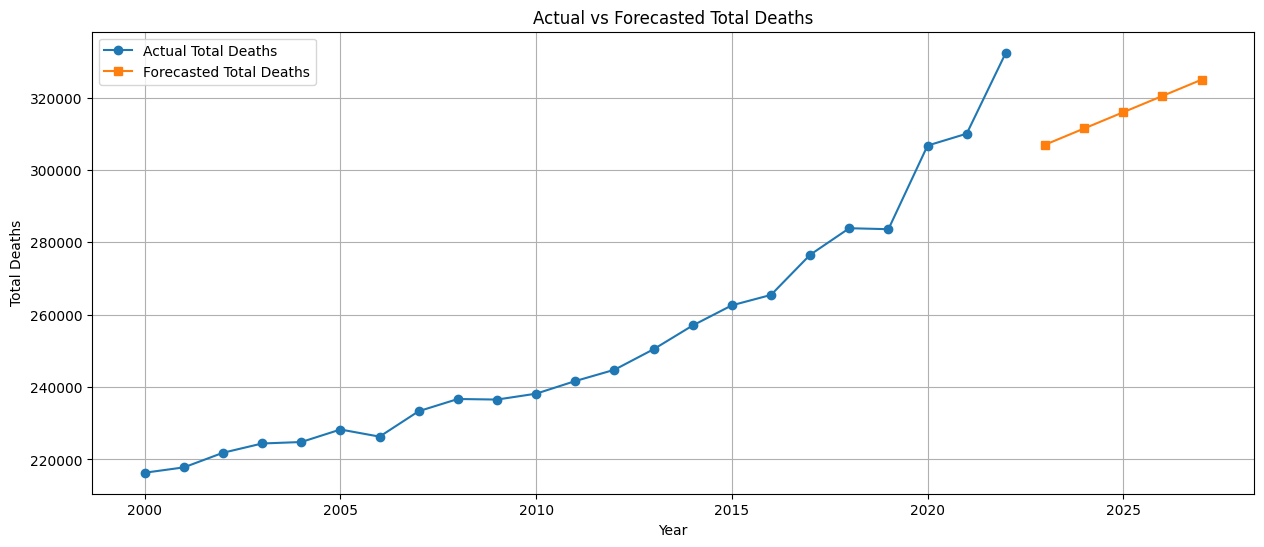

In [155]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Prepare the data by creating a feature vector and label column
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
data = assembler.transform(deaths_by_year)

# Train a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Total Deaths")
lr_model = lr.fit(data)

# Use the trained model to make predictions for the next 5 years
future_years = [2023, 2024, 2025, 2026, 2027]
future_data = assembler.transform(spark.createDataFrame([(year,) for year in future_years], ["Year"]))
future_predictions = lr_model.transform(future_data)

# Visualize the predicted death rates
predictions_pd = data.select("Year", "Total Deaths").toPandas()
future_predictions_pd = future_predictions.select("Year", "prediction").toPandas()

plt.figure(figsize=(15, 6))
plt.plot(predictions_pd['Year'], predictions_pd['Total Deaths'], label='Actual Total Deaths', marker='o')
plt.plot(future_predictions_pd['Year'], future_predictions_pd['prediction'], label='Forecasted Total Deaths', marker='s')
plt.title('Actual vs Forecasted Total Deaths')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid(True)
plt.show()


In [157]:
# Stopping the spark session
spark.stop()

In [158]:
!stop-all.sh

Stopping namenodes on [0.0.0.0]
Stopping datanodes
Stopping secondary namenodes [Bikins-MacBook-Pro.local]
2024-04-11 03:51:53,323 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Stopping nodemanagers
Stopping resourcemanager
